<a href="https://colab.research.google.com/github/georgezefko/Recommender_System/blob/Matrix_approach/ABA_recommender_MF_14_05_21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [23]:
!pip install surprise

In [24]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from surprise import Reader, Dataset, SVD, SVDpp, NMF, KNNBaseline,CoClustering,KNNBasic, KNNWithMeans,KNNWithZScore,SlopeOne,accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold, GridSearchCV
from surprise import NormalPredictor
from surprise import BaselineOnly
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()


# Introduction

In this part we aim to build a recommender system for Olist based on collaborative filtering approach. The core principal for such kind of recommender is that the user is recommended items that people with similar tastes and preferences liked in the past. 
We will try several algorithms using the Surprise library in order to find the most optimal algorithm for our case.
Following the EDA part (see corresponding notebook) the initial idea behind the recommender system was to use additional features such as month, product category, time etc.. However, after carefull consideration we realized that this won't provide the desired outcome because it will create confusion to the models. Therefore solely the product id, customer id and reviews will be used.

#Further data pre-processing

Here we use the dataset called recommender.csv we obtained from the exploratory data analysis part. Before we build the 
recommender system on collaborative filtering we would like clean this dataset by removing the duplicates.

In [25]:
#import the dataset from EDA
#path = '/content/drive/MyDrive/AdvancedBA/Olie_data/'
path ='/content/drive/MyDrive/olist_project/'
data = pd.read_csv(path+'recommender.csv')

In [26]:
data.head()

,Unnamed: 0,review_score,customer_state,seller_state,product_id,product_category_name_english,customer_unique_id,order_delivered_customer_date,price,delivered_date,days_diff,order_weekday,order_month,price_category,day_category
0,0,4,SP,SP,17106,housewares,45758,2017-10-10 21:25:13,29.99,2017-10-10,8.0,Monday,Oct,Low,morning
1,1,4,SP,SP,17106,housewares,21530,2017-08-18 14:44:43,29.99,2017-08-18,3.0,Tuesday,Aug,Low,afternoon
2,2,5,SP,SP,17106,housewares,87936,2017-08-07 18:30:01,29.99,2017-08-07,5.0,Wednesday,Aug,Low,afternoon
3,3,3,SC,SP,17106,housewares,85228,2017-11-07 18:04:59,29.99,2017-11-07,15.0,Monday,Oct,Low,evening
4,4,1,SP,SP,23951,housewares,44958,2017-08-28 20:12:20,46.80,2017-08-28,4.0,Thursday,Aug,Low,morning


In [27]:
# remove the excess column in the beginning
data = data.iloc[:,1:]

In [28]:
data.shape

(111686, 14)

In [29]:
#drop duplicates for the chosen columns
data = data.loc[:,'customer_unique_id,product_id,review_score'.split(',')].drop_duplicates()

In [30]:
data.shape

(100882, 3)

### Product-User ratings distribution

Now we would like to see the distribution of ratings given by users. That is for instance how many users give only 2 ratings.
Also we would like to see the distribution of ratings given to products. That is for how many products are there with 20 ratings.

In [31]:
pro_rat = data.groupby('customer_unique_id')['review_score'].count()
pro_rev=data.groupby('product_id')['review_score'].count()

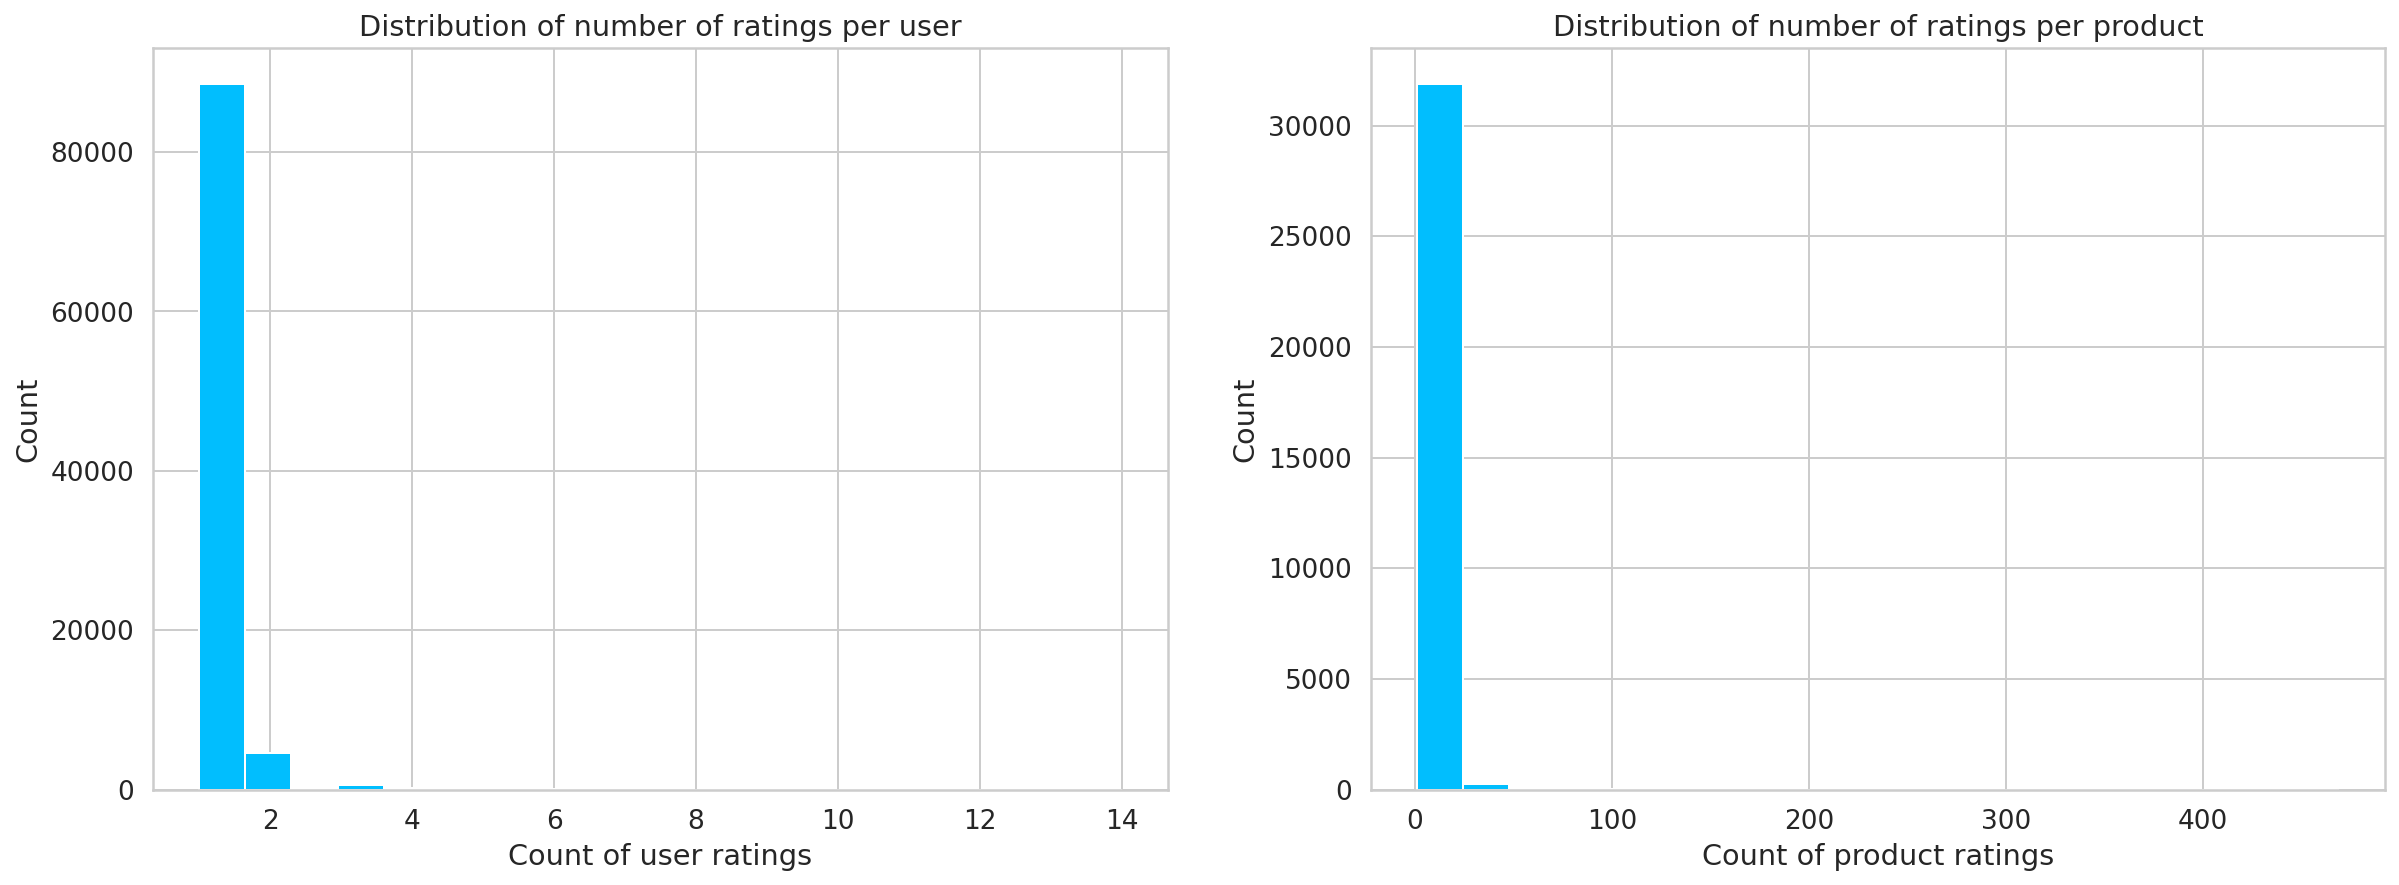

In [32]:
fig = plt.figure(figsize=(20,15))


fig.add_subplot(2,2,1)
pro_rat.hist(bins=20)
plt.xlabel('Count of user ratings')
plt.ylabel('Count')
plt.title('Distribution of number of ratings per user')

fig.add_subplot(2,2, 2)
pro_rev.hist(bins=20)
plt.xlabel('Count of product ratings')
plt.ylabel('Count')
plt.title('Distribution of number of ratings per product')

plt.show()

From the plots above we can see that we have many products that have received solely one review. Additionaly there majority of customers have provided only one review. 
In order to reduce dimensionality and to avoid the cold users/item issue we will remove users and items with only one review provided and given respectively.

In [33]:
#https://towardsdatascience.com/building-and-testing-recommender-systems-with-surprise-step-by-step-d4ba702ef80b
#remove rating and users than have been given/gotten only one review
min_product_ratings = 1
filter_products = data['product_id'].value_counts() > min_product_ratings
filter_products = filter_products[filter_products].index.tolist()


min_user_ratings = 1
filter_users = data['customer_unique_id'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

data_new = data[(data['product_id'].isin(filter_products)) & (data['customer_unique_id'].isin(filter_users))]

In [34]:
data_new

,customer_unique_id,product_id,review_score
0,45758,17106,4
50,54651,3315,4
54,18828,27150,1
95,18846,23621,1
134,79270,24487,5
...,...,...,...
111637,48527,32053,5
111647,66013,13293,5
111660,46303,16592,4
111676,34041,26630,1


# Recommender algorithms


In this part we will make use of the algorithms included in the surprise package in order to investigate which algorithm provides the optimal recommendations.
We will use the root mean squared error as accuracy metric. Below a description of algorithms is provided as derived from the surprise documentation.

##1. Basic algorithm

This is a basic algorithm that do not do much work but which is still useful for comparing accuracies.


<!-- **1.1 NormalPredictor**

A prediction value $\hat{r}_{u i}$ is given randomly according to the distribution characteristics of training set. This is one of the most basic algorithms that do not do much work. The prediction is generated from a normal distribution $
\mathcal{N}\left(\hat{\mu}, \hat{\sigma}^{2}\right)
$ where mean $\hat{\mu}$ and standard deviation $\hat{\sigma}$ are estimated from the training data using Maximum Likelihood Estimation where,

**$$
\hat{\mu}=\frac{1}{\left|R_{\text {train }}\right|} \sum_{r_{u i} \in R_{\text {train }}} r_{u i} 
$$**

and 

**$$
\hat{\sigma}=\sqrt{\sum_{r_{u i} \in R_{\text {train }}} \frac{\left(r_{u i}-\hat{\mu}\right)^{2}}{\left|R_{\text {train }}\right|}}
$$** -->


**1.2 BaselineOnly**

BaselineOnly algorithm predicts the baseline estimate for given user and item. The prediction $\hat{r}_{u i}$ is:

$$
\hat{r}_{u i}=b_{u i}=\mu+b_{u}+b_{i}
$$


Here the $b_{u}$ 
and $b_{i}$ are the user's bias and item's bias respectively. $\mu$ is the global mean rating or the average of all ratings. 
If user $\mu$ is unknown, then the bias $b_{u}$ is assumed to be zero. 
The same applies for item ${i}$ with $b_{i}$.






## 2. k-NN algorithms

These are algorithms that are directly derived from a basic nearest neighbors approach.

**2.1 KNNBasic**

KNNBasic is a basic collaborative filtering algorithm. The prediction $\hat{r}_{u i}$ is:

$$
\hat{r}_{u i}=\frac{\sum_{v \in N_{i}^{k}(u)} \operatorname{sim}(u, v) \cdot r_{v i}}{\sum_{v \in N_{i}^{k}(u)} \operatorname{sim}(u, v)}
$$  or     $$\hat{r}_{u i}=\frac{\sum_{j \in N_{u}^{k}(i)} \operatorname{sim}(i, j) \cdot r_{u j}}{\sum_{j \in N_{u}^{k}(i)} \operatorname{sim}(i, j)}
$$ 

Here the $r_{v i}$ and $r_{u j}$ are the rating given to item $i$ by the user $v$ and rating given to item $j$ by user $u$ respectively. ${sim}(u, v)$ and ${sim}(i, j)$ are the similarity between user $u$ & $v$ and similarity between item $i$ & $j$ respectively. 
The first $\hat{r}_{u i}$ is collaborative filering based on user similarity. 
The second $\hat{r}_{u i}$ is collaborative filering based on item similarity. The formula depends on the user_based field of the sim_options parameter. If we put user_based = False it computes similarity between items. Therefore we can compute Similarities  between either users or items. This has a huge impact on the performance of a prediction algorithm.


**2.2 KNNWithMeans**

KNNWithMeans is basic collaborative filtering algorithm, taking into account the mean ratings of each user. The prediction $\hat{r}_{u i}$ is:

$$
\hat{r}_{u i}=\mu_{u}+\frac{\sum_{v \in N_{i}^{k}(u)} \operatorname{sim}(u, v) \cdot\left(r_{v i}-\mu_{v}\right)}{\sum_{v \in N_{i}^{k}(u)} \operatorname{sim}(u, v)}
$$

or 

$$
\hat{r}_{u i}=\mu_{i}+\frac{\sum_{j \in N_{u}^{k}(i)} \operatorname{sim}(i, j) \cdot\left(r_{u j}-\mu_{j}\right)}{\sum_{j \in N_{u}^{k}(i)} \operatorname{sim}(i, j)}
$$. 

This is same as the KNNBasic algorithm discussed above, the only difference is the usage of mean rating of users or items into the prediction. Same as the KNNBasic algorithm the formula depends on the user_based field of the sim_options parameter. 
This algorithm is better than the KNNBasic algorithm because this accounts for the average user's ratings represented by $\mu_{u}$ 
and $\mu_{v}$)
or the average item ratings represented by $\mu_{i}$ 
and $\mu_{j}$) to the prediction. The average user rating can be also interpreted as how generous or tough a rater or user is. It allows to center or normalize the values.


**2.3 KNNWithZScore**

KNNWithZScore is a basic collaborative filtering algorithm, taking into account the z-score normalization of each user. The prediction $\hat{r}_{u i}$ is:

$$
\hat{r}_{u i}=\mu_{u}+\sigma_{u} \frac{\sum_{v \in N_{i}^{k}(u)} \operatorname{sim}(u, v) \cdot\left(r_{v i}-\mu_{v}\right) / \sigma_{v}}{\sum_{v \in N_{i}^{k}(u)} \operatorname{sim}(u, v)}
$$

or

$$
\hat{r}_{u i}=\mu_{i}+\sigma_{i} \frac{\sum_{j \in N_{u}^{k}(i)} \operatorname{sim}(i, j) \cdot\left(r_{u j}-\mu_{j}\right) / \sigma_{j}}{\sum_{j \in N_{u}^{k}(i)} \operatorname{sim}(i, j)}
$$

This is also same as the KNNWithMeans algorithm,the only difference is it takes the Z-score normalization of each user or the each item. This formula also depends on the user_based field of the sim_options parameter. If standard deviation $\sigma$ is 0, then the overall sigma is used in that case.



**2.4 KNNBaseline**

KNNBaseline is a basic collaborative filtering algorithm taking into account a baseline rating. The prediction $\hat{r}_{u i}$ is:

$$
\hat{r}_{u i}=b_{u i}+\frac{\sum_{v \in N_{i}^{k}(u)} \operatorname{sim}(u, v) \cdot\left(r_{v i}-b_{v i}\right)}{\sum_{v \in N_{i}^{k}(u)} \operatorname{sim}(u, v)}
$$

or 

$$
\hat{r}_{u i}=b_{u i}+\frac{\sum_{j \in N_{u}^{k}(i)} \operatorname{sim}(i, j) \cdot\left(r_{u j}-b_{u j}\right)}{\sum_{j \in N_{u}^{k}(i)} \operatorname{sim}(i, j)}
$$

depending on the user_based field of the sim_options parameter. 
This gives best predictions, when we use the pearson baseline similarity measure. The only difference here with KNNBasic is this use baseline ratings given by users to items which are represented by 
$b_{u i}$ ,
$b_{v i}$ , 
$b_{u j}$.


## 3. Matrix Factorization-based algorithms

Matrix factorization is a famous class of collaborative filtering algorithms used in recommender systems. Matrix factorization algorithms work by decomposing the user-item interaction matrix into the product of two lower dimensionality matrices.Latent features, the association between users and products matrices, are determined to find similarity and make a prediction based on both item and user entities. The advantage of this method is it want the reconstruction error to be small on known ratings and do not care about the values on the missing ones.

**3.1 SVD**

SVD algorithm is equivalent to Probabilistic Matrix Factorization when baselines are not used. The prediction $\hat{r}_{u i}$ is:

$$
\hat{r}_{u i}=\mu+b_{u}+b_{i}+q_{i}^{T} p_{u}
$$

Here the $\mu$, $b_{u}$, $b_{i}$, $q_{i}$ 
and $p_{u}$ are the global mean rating, bias for user $u$, bias for item $i$, item factors and the user factors respectively. 
If user $\mu$ is unknown, then the bias $b_{u}$ 
and the factors $p_{u}$ are assumed to be zero. 
The same applies for item $i$ with $b_{i}$ 
and $q_{i}$. To estimate all the unknown, we minimize the regularized squared error and the minimization is performed by the stochastic gradient descent.

**3.2 SVDpp**

The SVDpp algorithm is an extension of SVD that takes into account implicit ratings. The prediction $\hat{r}_{u i}$ is:

$$
\hat{r}_{u i}=\mu+b_{u}+b_{i}+q_{i}^{T}\left(p_{u}+\left|I_{u}\right|^{-\frac{1}{2}} \sum_{j \in I_{u}} y_{j}\right)
$$

The only difference here with SVD algorithm is usage if implicit ratings into the prediction. 
The (implicit) item factors $y_{j}$ 
are a new set of item factors that capture implicit ratings. Here, an implicit rating describes the fact that a user $u$ rated an item $j$, regardless of the rating value. If user $u$ is unknown, then the bias $b_{u}$ 
and the factors $p_{u}$ 
are assumed to be zero. The same applies for item $i$ with $b_{i}$, $q_{i}$ and $y_{i}$. Just as for SVD, the parameters are learned using a stochastic gradient descent on the regularized squared error minimization.

**3.3 NMF**

NMF is a collaborative filtering algorithm based on Non-negative Matrix Factorization. It is very similar to SVD. The prediction $\hat{r}_{u i}$ is:

$$
\hat{r}_{u i}=q_{i}^{T} p_{u}
$$

Here we keep user and item factors as positive. The optimization procedure is a regularized stochastic gradient descent with a specific choice of step size that ensures non-negativity of factors, provided that their initial values are also positive.

**3.4 NMF Biased**

This is the biased version of Non-negative Matrix Factorization. This can be achieved by setting the biased parameter to True. In this case, the prediction is:

$$
\hat{r}_{u i}=\mu+b_{u}+b_{i}+q_{i}^{T} p_{u}
$$

This also takes the positive factors. Baselines are optimized in the same way as in the SVD algorithm. Eventhough this gives better accuracy, this is highly prone to overfitting so it is important to reduce the number of factors or increase regularization.



## 4. Clustering algorithm

**4.1 Co-clustering**

Coclustering is a collaborative filtering algorithm based on co-clustering.
Basically, users and items are assigned some clusters 
$C_{u}$, $C_{i}$, 
and some co-clusters $C_{u i}$.

The prediction $\hat{r}_{u i}$ is:

$$
\hat{r}_{u i}=\overline{C_{u i}}+\left(\mu_{u}-\overline{C_{u}}\right)+\left(\mu_{i}-\overline{C_{i}}\right)
$$

where $\overline{C_{u i}}$ is the average rating of co-cluster $C_{u i}$, $\overline{C_{u}}$ is the average rating of u’s cluster, and $\overline{C_{i}}$ is the average rating of i’s cluster. If the user is unknown, the prediction is $\hat{r}_{u i}$ =$\mu_{i}$. If the item is unknown, the prediction is $\hat{r}_{u i}$ =$\mu_{u}$. If both the user and the item are unknown, the prediction is $\hat{r}_{u i}$ =$\mu$.



##Implementation of algorithms##

First we need to prepare the data to the right form as required from the surprise library

In [35]:
ratings_df = data_new[['customer_unique_id','product_id','review_score']]

In [36]:
#split the data to train and test
train_df, test_df = train_test_split(ratings_df, train_size=0.7, random_state = 0) # 2/3 -training 

We use a function called performance to get the predictions from the best parameters of the algorithm. Also, We would like to see the accuracy or the performance of the algorithm at the end using root mean squred error.

In [37]:
# function to calculate the RMSE
def RMSE(y_true, y_pred):
    return np.linalg.norm(y_true - y_pred) / np.sqrt(len(y_true))

In [39]:
def performance(user,product,model):
  y_pred = []
  for user_id, product_id in zip(user, product):
    r = model.predict(user_id, product_id, verbose=False).est 
    y_pred.append(r)
  y_pred = np.array(y_pred)
  return y_pred

In [40]:
def recommendations(user,product,model):
  
  recommendations = []
  for product_id in  product:
    r = model.predict(user, product_id, verbose=False).est 
    recommendations.append((product_id,r))
   
  recommendations.sort(reverse=True, key=lambda x: x[1])

  return recommendations[:5]

In [41]:
reader = Reader(rating_scale=(1,5))
data_surprise = Dataset.load_from_df(train_df, reader)


Now we would like to implement the above discussed models by first finding the best parameters using grid search cross validation. Then we use those best parameters to fit the model and get the predictions. Finally we get the accuracy of the fitted models using the RMSE score.

In [ ]:
# chosen models
models = ['svd','svd++','nmfb','nmf','CoClustering','KNNBasic','KNNWithMeans','KNNWithZScore','KNNBaseline', 'BaselineOnly']

# values needed for predictions
y_true = test_df['review_score'].values 
user_ids_true = test_df['customer_unique_id'].values
product_ids_true = test_df['product_id'].values



for i in models:
  if i == 'svd':
    param_grid = {'n_factors': [70, 80, 90, 100, 110, 120, 130, 140, 150, 160], 
                  'n_epochs': [100], 
                  'reg_all': [0.1]}
    gs_svd = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3) # cross validation 3-folds
    gs_svd.fit(data_surprise)
    best_svd = gs_svd.best_score['rmse']
    best_svd_params = gs_svd.best_params['rmse']
    model_svd = gs_svd.best_estimator['rmse']
    model_svd.fit(data_surprise.build_full_trainset())
    y_pred_svd = performance(user_ids_true,product_ids_true,model_svd)
    error_svd = RMSE(y_true, y_pred_svd)
  
  elif i == 'svd++':
    param_grid = {'lr_all': [0.001, 0.003, 0.005, 0.007, 0.009], 
                  'reg_all': [0.005, 0.01, 0.015, 0.02, 0.025]}
    gs_svdpp = GridSearchCV(SVDpp, param_grid, measures=['rmse'], cv=3)
    gs_svdpp.fit(data_surprise)
    best_svd_plus = gs_svdpp.best_score['rmse']
    best_svd_plus_params = gs_svdpp.best_params['rmse']
    model_svd_plus = gs_svdpp.best_estimator['rmse']
    model_svd_plus.fit(data_surprise.build_full_trainset())
    y_pred_svd_plus = performance(user_ids_true,product_ids_true,model_svd_plus)
    error_svd_plus = RMSE(y_true, y_pred_svd_plus)


  elif i == 'nmfb':
    param_grid = {'n_factors': [1,2,3,4,5,6,7,8,9,10], 
                  'n_epochs': [100], 
                  'biased': [True], 
                  'reg_bu': [0.06,0.1,0.2], 
                  'reg_bi': [0.06,0.1,0.2]}
    gs_nmfb = GridSearchCV(NMF, param_grid, measures=['rmse'], cv=3)
    gs_nmfb.fit(data_surprise)
    best_nmfb = gs_nmfb.best_score['rmse']
    best_nmfb_params = gs_nmfb.best_params['rmse']
    model_nmfb = gs_nmfb.best_estimator['rmse']
    model_nmfb.fit(data_surprise.build_full_trainset())
    y_pred_nmfb = performance(user_ids_true,product_ids_true,model_nmfb)
    error_nmfb = RMSE(y_true, y_pred_nmfb)

  elif i == 'nmf':
    param_grid = {'n_factors': [200, 220, 240], 
                  'n_epochs': [100]}
    gs_nmf = GridSearchCV(NMF, param_grid, measures=['rmse'], cv=3)
    gs_nmf.fit(data_surprise)
    best_nmf = gs_nmf.best_score['rmse']
    best_nmf_params = gs_nmf.best_params['rmse']
    model_nmf = gs_nmf.best_estimator['rmse']
    model_nmf.fit(data_surprise.build_full_trainset())
    y_pred_nmf = performance(user_ids_true,product_ids_true,model_nmf)
    error_nmf = RMSE(y_true, y_pred_nmf)

  elif i == 'CoClustering':
    param_grid = {'n_cltr_u': [3,4,5], 
                  'n_cltr_i': [3,4,5],'n_epochs':[20,100]}
    gs_CoClustering = GridSearchCV(CoClustering, param_grid, measures=['rmse'], cv=3)
    gs_CoClustering.fit(data_surprise)
    best_CoClustering = gs_CoClustering.best_score['rmse']
    best_CoClustering_params = gs_CoClustering.best_params['rmse']
    model_CoClustering = gs_CoClustering.best_estimator['rmse']
    model_CoClustering.fit(data_surprise.build_full_trainset())
    y_pred_CoClustering = performance(user_ids_true,product_ids_true,model_CoClustering)
    error_CoClustering = RMSE(y_true, y_pred_CoClustering)
    
  elif i == 'KNNBasic':
    param_grid = {'k': [40, 50, 60], 'sim_options': {'user_based': [True, False]}}
    gs_KNNBasic = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3)
    gs_KNNBasic.fit(data_surprise)
    best_KNNBasic = gs_KNNBasic.best_score['rmse']
    best_KNNBasic_params = gs_KNNBasic.best_params['rmse']
    model_KNNBasic = gs_KNNBasic.best_estimator['rmse']
    model_KNNBasic.fit(data_surprise.build_full_trainset())
    y_pred_KNNBasic = performance(user_ids_true,product_ids_true,model_KNNBasic)
    error_KNNBasic = RMSE(y_true, y_pred_KNNBasic)

  elif i == 'KNNWithMeans':
    param_grid = {'k': [40, 50, 60], 'sim_options': {'user_based': [True, False]}}
    gs_KNNWithMeans = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse'], cv=3)
    gs_KNNWithMeans.fit(data_surprise)
    best_KNNWithMeans = gs_KNNWithMeans.best_score['rmse']
    best_KNNWithMeans_params = gs_KNNWithMeans.best_params['rmse']
    model_KNNWithMeans = gs_KNNWithMeans.best_estimator['rmse']
    model_KNNWithMeans.fit(data_surprise.build_full_trainset())
    y_pred_KNNWithMeans = performance(user_ids_true,product_ids_true,model_KNNWithMeans)
    error_KNNWithMeans = RMSE(y_true, y_pred_KNNWithMeans)

  elif i == 'KNNWithZScore':
    param_grid = {'k': [40, 50, 60], 'sim_options': {'user_based': [True, False]}}
    gs_KNNWithZScore = GridSearchCV(KNNWithZScore, param_grid, measures=['rmse'], cv=3)
    gs_KNNWithZScore.fit(data_surprise)
    best_KNNWithZScore = gs_KNNWithZScore.best_score['rmse']
    best_KNNWithZScore_params = gs_KNNWithZScore.best_params['rmse']
    model_KNNWithZScore = gs_KNNWithZScore.best_estimator['rmse']
    model_KNNWithZScore.fit(data_surprise.build_full_trainset())
    y_pred_KNNWithZScore = performance(user_ids_true,product_ids_true,model_KNNWithZScore)
    error_KNNWithZScore = RMSE(y_true, y_pred_KNNWithZScore)

  elif i == 'KNNBaseline':
    param_grid = {'k': [40, 50, 60], 'sim_options': {'user_based': [True, False]},
              'bsl_options': {'method': ['als', 'sgd']}}
    gs_KNNBaseline = GridSearchCV(KNNBaseline, param_grid, measures=['rmse'], cv=3)
    gs_KNNBaseline.fit(data_surprise)
    best_KNNBaseline = gs_KNNBaseline.best_score['rmse']
    best_KNNBaseline_params = gs_KNNBaseline.best_params['rmse']
    model_KNNBaseline = gs_KNNBaseline.best_estimator['rmse']
    model_KNNBaseline.fit(data_surprise.build_full_trainset())
    y_pred_KNNBaseline = performance(user_ids_true,product_ids_true,model_KNNBaseline)
    error_KNNBaseline = RMSE(y_true, y_pred_KNNBaseline)

  elif i == 'BaselineOnly':
    param_grid = {'bsl_options': {'method': ['als', 'sgd']}
               }
    gs_Baseline = GridSearchCV(BaselineOnly, param_grid, measures=['rmse'], cv=3)
    gs_Baseline.fit(data_surprise)
    best_Baseline = gs_Baseline.best_score['rmse']
    best_Baseline_params = gs_Baseline.best_params['rmse']
    model_Baseline = gs_Baseline.best_estimator['rmse']
    model_Baseline.fit(data_surprise.build_full_trainset())
    y_pred_Baseline = performance(user_ids_true,product_ids_true,model_Baseline)
    error_Baseline = RMSE(y_true, y_pred_Baseline)




# Results summary

We would like to see the best Best parameters we got for each model using the grid search cross validation. Here the best score is the best RMSE we got from Grid search.

In [52]:
print(f'The best Baseline score: {best_Baseline}\nThe best Baseline parameters are: {best_Baseline_params}')
print(80*'-')
print(f'The best SVD score: {best_svd}\nThe best SVD parameters are: {best_svd_params}')
print(80*'-')
print(f'The best SVD++ score: {best_svd_plus}\nThe best SVD++ parameters are: {best_svd_plus_params}')
print(80*'-')
print(f'The best Biased NMF score: {best_nmfb}\nThe best Biased NMF parameters are: {best_nmfb_params}')
print(80*'-')
print(f'The best NMF score: {best_nmf}\nThe best NMF parameters are: {best_nmf_params}')
print(80*'-')
print(f'The best CoClustering score: {best_CoClustering}\nThe best CoClustering parameters are: {best_CoClustering_params}')
print(80*'-')
print(f'The best KNNBasic score: {best_KNNBasic}\nThe best KNNBasic parameters are: {best_KNNBasic_params}')
print(80*'-')
print(f'The best KNNWithMeans score: {best_KNNWithMeans}\nThe best KNNWithMeans parameters are: {best_KNNWithMeans_params}')
print(80*'-')
print(f'The best KNNWithZScore score: {best_KNNWithZScore}\nThe best KNNWithZScore parameters are: {best_KNNWithZScore_params}')
print(80*'-')
print(f'The best KNNBaseline score: {best_KNNBaseline}\nThe best KNNBaseline parameters are: {best_KNNBaseline_params}')
print(80*'-')


The best Baseline score: 1.5260887904271596
The best Baseline parameters are: {'bsl_options': {'method': 'sgd'}}
--------------------------------------------------------------------------------
The best SVD score: 1.4870897585413256
The best SVD parameters are: {'n_factors': 70, 'n_epochs': 100, 'reg_all': 0.1}
--------------------------------------------------------------------------------
The best SVD++ score: 1.506484646183156
The best SVD++ parameters are: {'lr_all': 0.009, 'reg_all': 0.025}
--------------------------------------------------------------------------------
The best Biased NMF score: 1.4803230197139836
The best Biased NMF parameters are: {'n_factors': 1, 'n_epochs': 100, 'biased': True, 'reg_bu': 0.06, 'reg_bi': 0.2}
--------------------------------------------------------------------------------
The best NMF score: 1.5331139327342669
The best NMF parameters are: {'n_factors': 240, 'n_epochs': 100}
----------------------------------------------------------------------

We would like to plot the Best RMSE we got from parameter tunning to see which model gives the lowest RMSE.

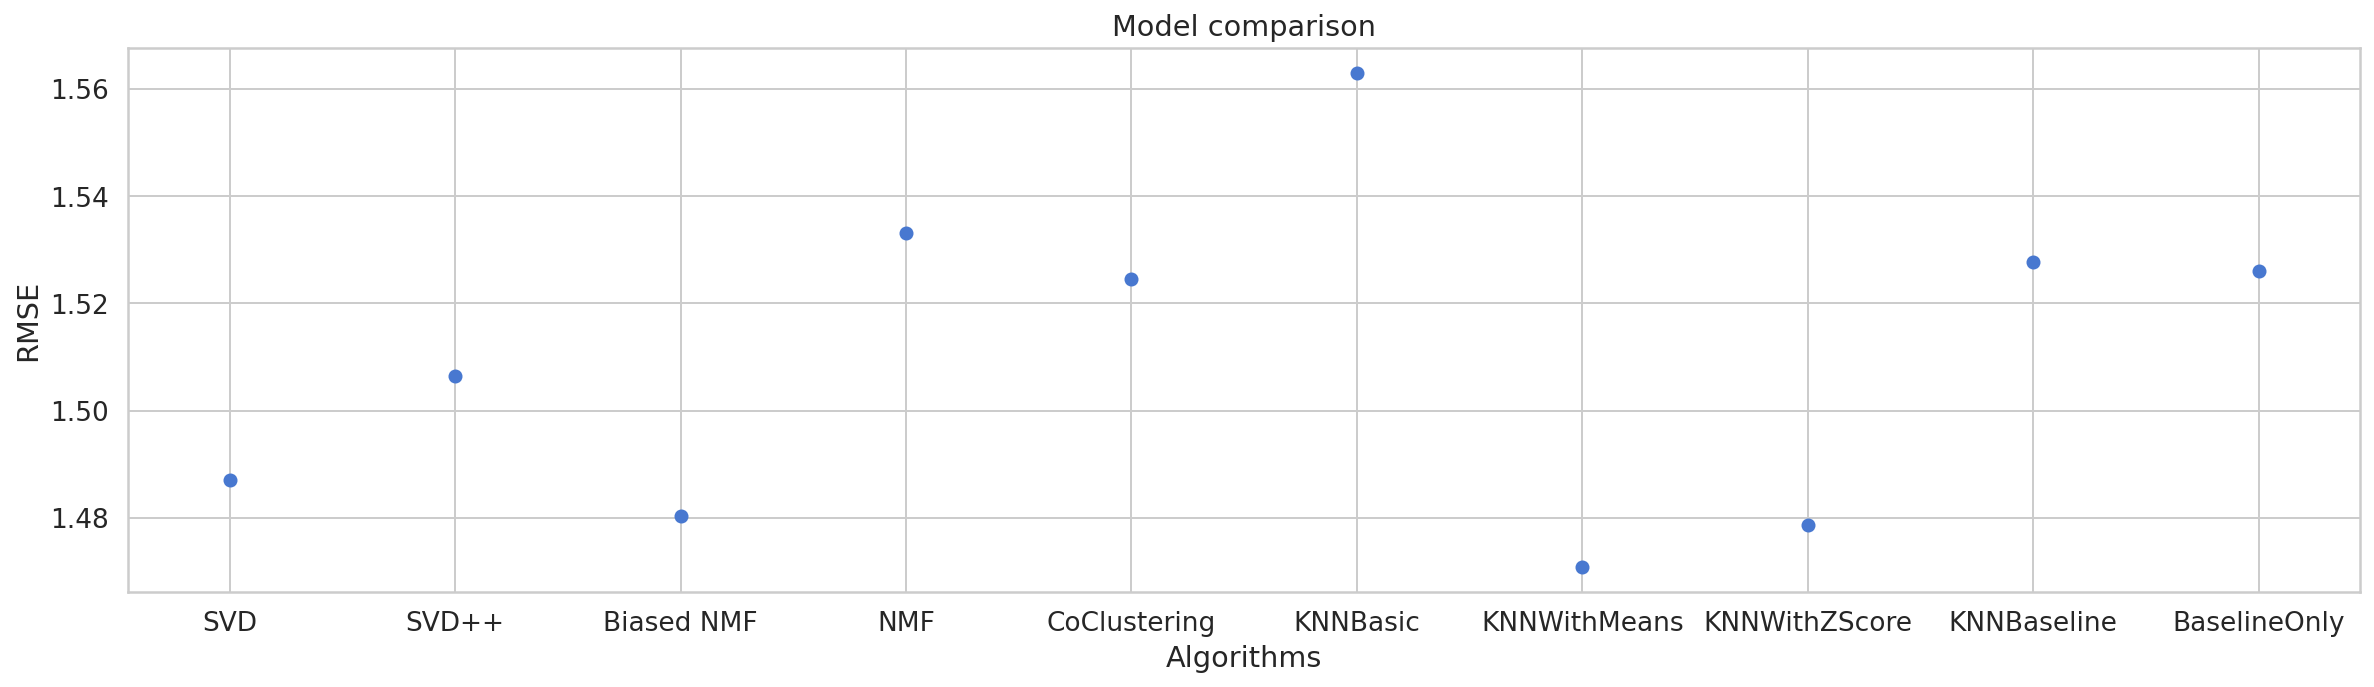

In [53]:
import matplotlib.pyplot as plt
BEST_RMSE = [best_svd, best_svd_plus, best_nmfb, best_nmf, best_CoClustering,best_KNNBasic,best_KNNWithMeans,best_KNNWithZScore,best_KNNBaseline,best_Baseline]
algorithms = ['SVD', 'SVD++', "Biased NMF", 'NMF', 'CoClustering','KNNBasic','KNNWithMeans','KNNWithZScore','KNNBaseline', 'BaselineOnly']

plt.figure(figsize=(20,5))
plt.plot(algorithms, BEST_RMSE,'bo' )
plt.xlabel("Algorithms")
plt.ylabel("RMSE")
plt.title('Model comparison')
plt.show()

We can clearly see that KNNWithMeans & KNNWithZScore RMSE values are almost identical and they are the lowest. However KNNBasic is the higest RMSE out of all models eventhough it is also a KNN algorithm. The Biased NMF is the best model out of matrix factorization algorithms.

We would also like to see the performance of our models through RMSE scores we got from predictions & true ratings.

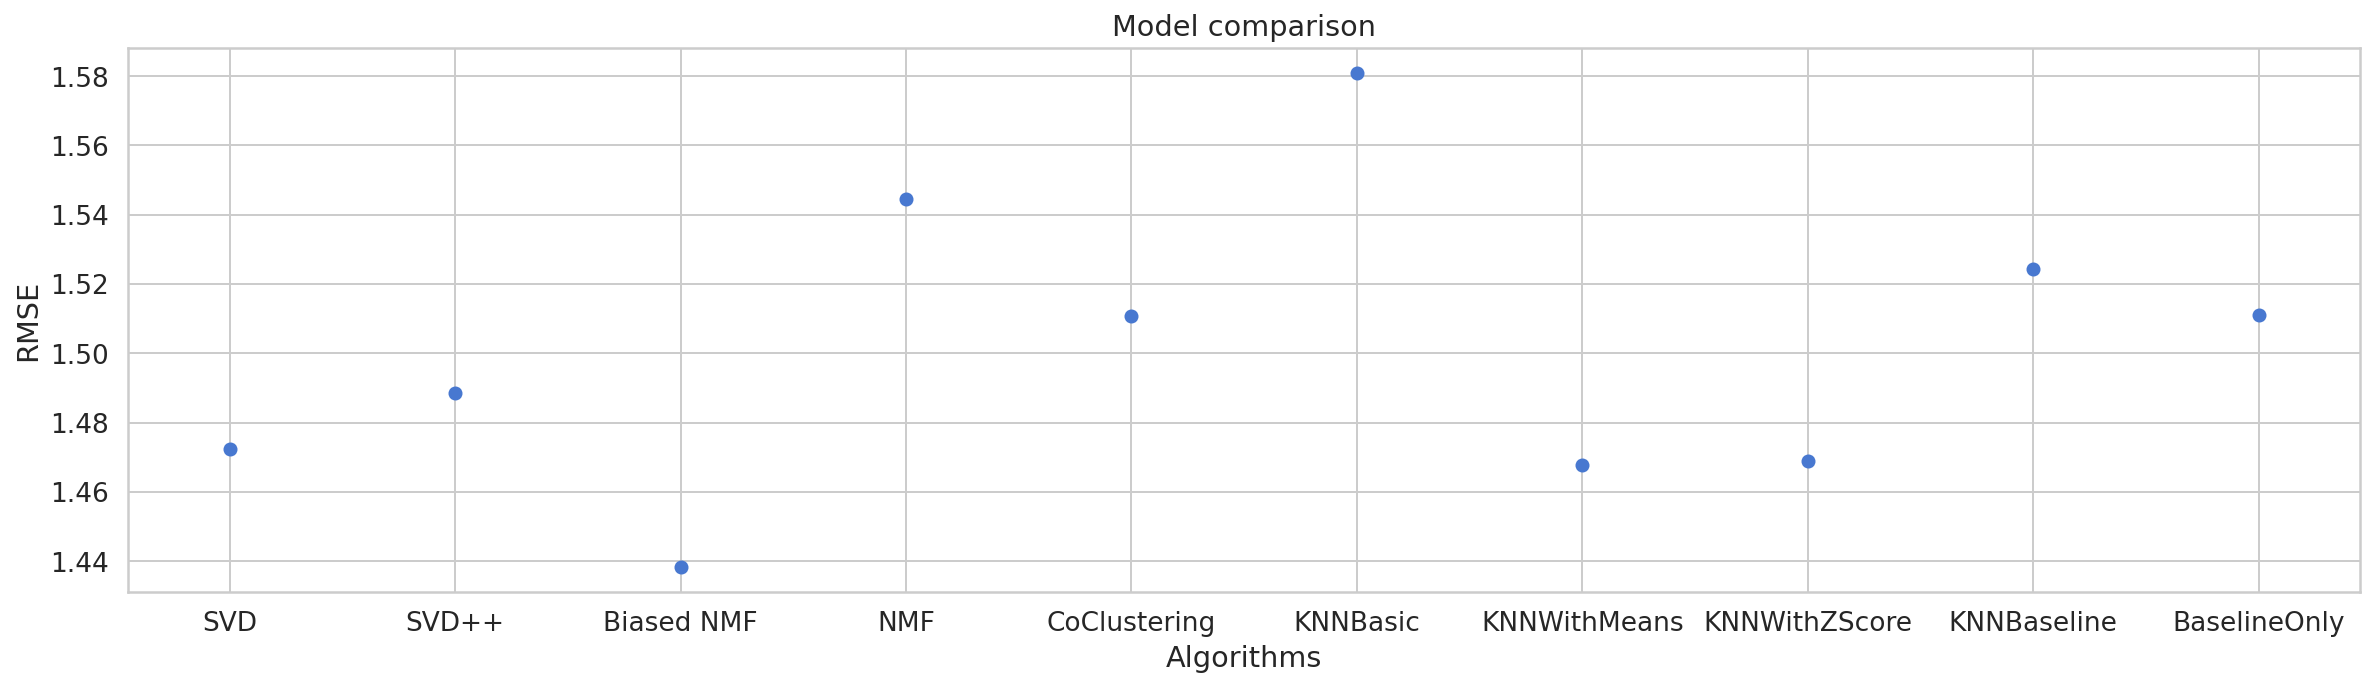

In [54]:
import matplotlib.pyplot as plt
RMSEs = [error_svd, error_svd_plus, error_nmfb, error_nmf, error_CoClustering,error_KNNBasic,error_KNNWithMeans,error_KNNWithZScore,error_KNNBaseline,error_Baseline]
algorithms = ['SVD', 'SVD++', "Biased NMF", 'NMF', 'CoClustering','KNNBasic','KNNWithMeans','KNNWithZScore','KNNBaseline', 'BaselineOnly']

plt.figure(figsize=(20,5))
plt.plot(algorithms, RMSEs,'bo' )
plt.xlabel("Algorithms")
plt.ylabel("RMSE")
plt.title('Model comparison')
plt.show()


Similar to the previous graph the performance doesn't follow a specific pattern. For example the 3 out of 4 matrix factorization algorithms record a very good performance while the NMF has the second worst one across the range of all algorithms. The same applies for the nearest neighbor algorithms where KNNWithMeans and KNNWithZscore have a low RMSE score and at the same time the KNN basic and KNNBaseline have significanlty larger RMSE score. KNNBasic performance is even lower than the Baseline only algorithm. So we can identify best 3 models as Biased NMF, KNNWithMeans and KNNWithZScore. Even though Biased NMF yields better accuracy, it is important to mention that the biased version seems highly prone to overfitting so you may want to reduce the number of factors (or increase regularization).

## Recommendations based on best models

Below we can see the top 5 recommendations for a user according to the top 3 winning models which was the Biased NMF,KNNWithMeans and KNNWithZScore

In [55]:
#Biased NMF
recommendations(user_ids_true[0],product_ids_true,model_nmfb)

[(5246, 3.7118078474976284),
 (11907, 3.613787249508927),
 (8960, 3.607016159800285),
 (17720, 3.505385877277402),
 (17720, 3.505385877277402)]

In [56]:
#KNNWithMeans
recommendations(user_ids_true[0],product_ids_true,model_KNNWithMeans)

[(30112, 3.6847080347613965),
 (6576, 3.6847080347613965),
 (15895, 3.6847080347613965),
 (13790, 3.6847080347613965),
 (20627, 3.6847080347613965)]

In [57]:
#KNNWithScore
recommendations(user_ids_true[0],product_ids_true,model_KNNWithZScore)

[(30112, 3.6847080347613965),
 (6576, 3.6847080347613965),
 (15895, 3.6847080347613965),
 (13790, 3.6847080347613965),
 (20627, 3.6847080347613965)]

We can see that the two KNN models provide the same recommendations while the Biased NMF gives completely different ones. The main reason could be beacuse the KNN models are based on basic nearest neighbors approach and biased NMF is based on matrix factorization approach which are two different models. 

#Conclusion

Throughout this notebook we applied 10 different models in order to achieve the best recommendations for the customers. The best model was a matrix factorization algorithm namely Biased NMF following by two KNN algorithms.
The recommendations among them where quite different which could be because of the completely different methodology. Even though Biased NMF yields better accuracy, it is important to mention that the biased version seems highly prone to overfitting so it is important to reduce the number of factors or increase the regularization when we want to get the right results. Eventhough we tried to implement a contenet based filtering model for the recommendations the results were not reasonable due to the the limited information regarding the contents of the products. Therefore if the Olist can provide more details about the contents of the products, content based filtering approach could be used as a comparison model for the collaborative filtering recommendations.   
